About the forest fire dataset:-
The aim is to predict the burned area of forest fires by by using meteorological and other data.
The dataset has been taken from UCI Machine Learning Repository.

http://archive.ics.uci.edu/ml/datasets/Forest+Fires

X - x-axis spatial coordinate within the Montesinho park map: 1 to 9

Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9

month - month of the year: "jan" to "dec"

day - day of the week: "mon" to "sun"

FFMC - FFMC index from the FWI system: 18.7 to 96.20

DMC - DMC index from the FWI system: 1.1 to 291.3

DC - DC index from the FWI system: 7.9 to 860.6

ISI - ISI index from the FWI system: 0.0 to 56.10

temp - temperature in Celsius degrees: 2.2 to 33.30

RH - relative humidity in %: 15.0 to 100

wind - wind speed in km/h: 0.40 to 9.40

rain - outside rain in mm/m2 : 0.0 to 6.4

area - the burned area of the forest (in ha): 0.00 to 1090.84

In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesRegressor

import seaborn as sns

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [3]:
df=pd.read_csv('forestfires.csv')

In [4]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [5]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


In [7]:
target = 'area'

In [8]:
df.isna().sum().sum() #check for any missing values in dataframe

0

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


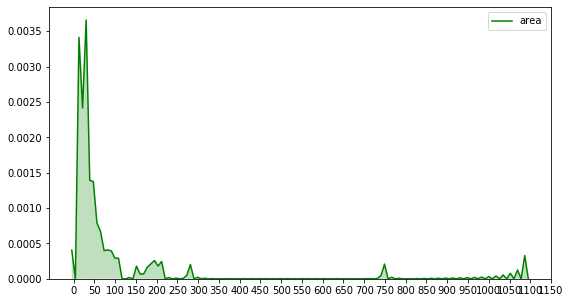

In [9]:
plt.figure(figsize=(9,5))
print("Skew: {}".format(df[target].skew()))
print("Kurtosis: {}".format(df[target].kurtosis()))
ax = sns.kdeplot(df[target],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

:]The data is highly skewed with a value of +12.84 and huge kurtosis value of 194.

:]It even tells us that majority of the forest fires do not cover a large area, most of the damaged area is under 50 hectares of land.


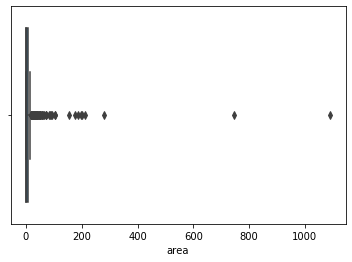

In [10]:
#check for outliers
ax = sns.boxplot(df[target])

In [11]:
#few outliers are present in the area column 
from scipy.stats import zscore
y_outliers = df[abs(zscore(df[target])) >= 3] 
y_outliers

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53


In [12]:
#distinguish categorical and numerical coloumns
dfa = df.drop(columns=target)
cat_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()

cat_columns,num_columns

(['month', 'day'],
 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'])

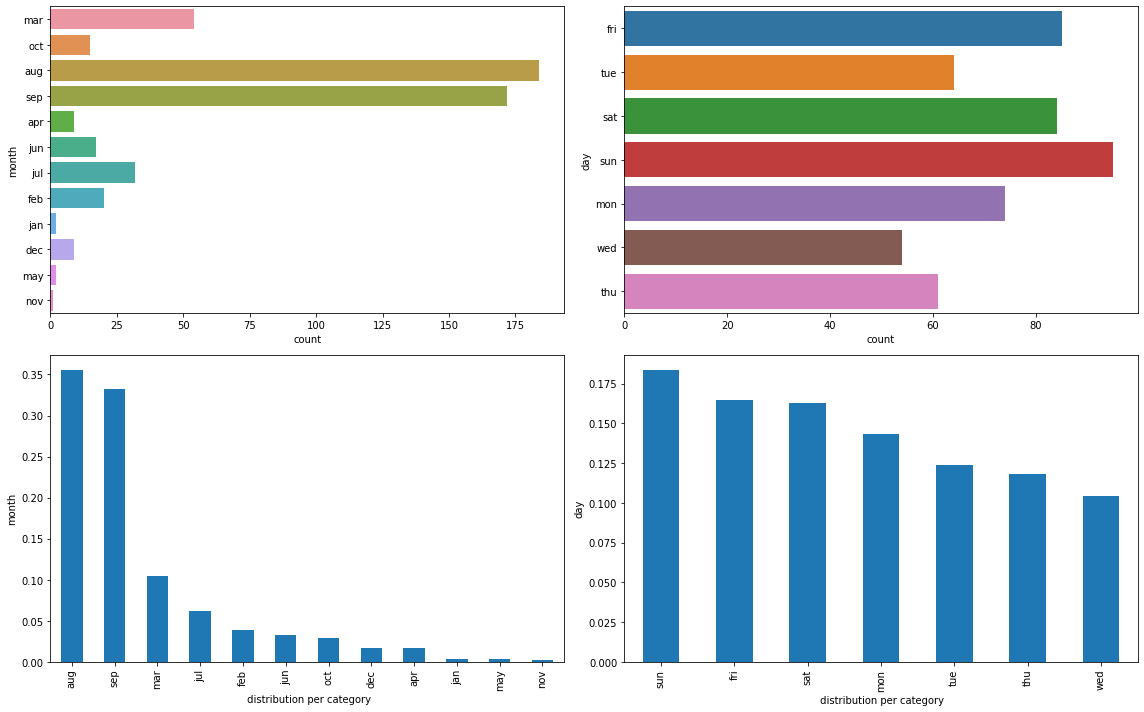

In [13]:
# analyzing categorical columns
plt.figure(figsize=(16,10))
for i,col in enumerate(cat_columns,1):
    plt.subplot(2,2,i)
    sns.countplot(data=dfa,y=col)
    plt.subplot(2,2,i+2)
    df[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel(' distribution per category')
plt.tight_layout()
plt.show()    

From the above analysis it can be concluded that-

1.Abnormally there are high number of the forest fires occuring in the month of August and September.

2.In the case of day, the days Friday to Monday have higher proportion of cases.

C:\Users\S K Prusti\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


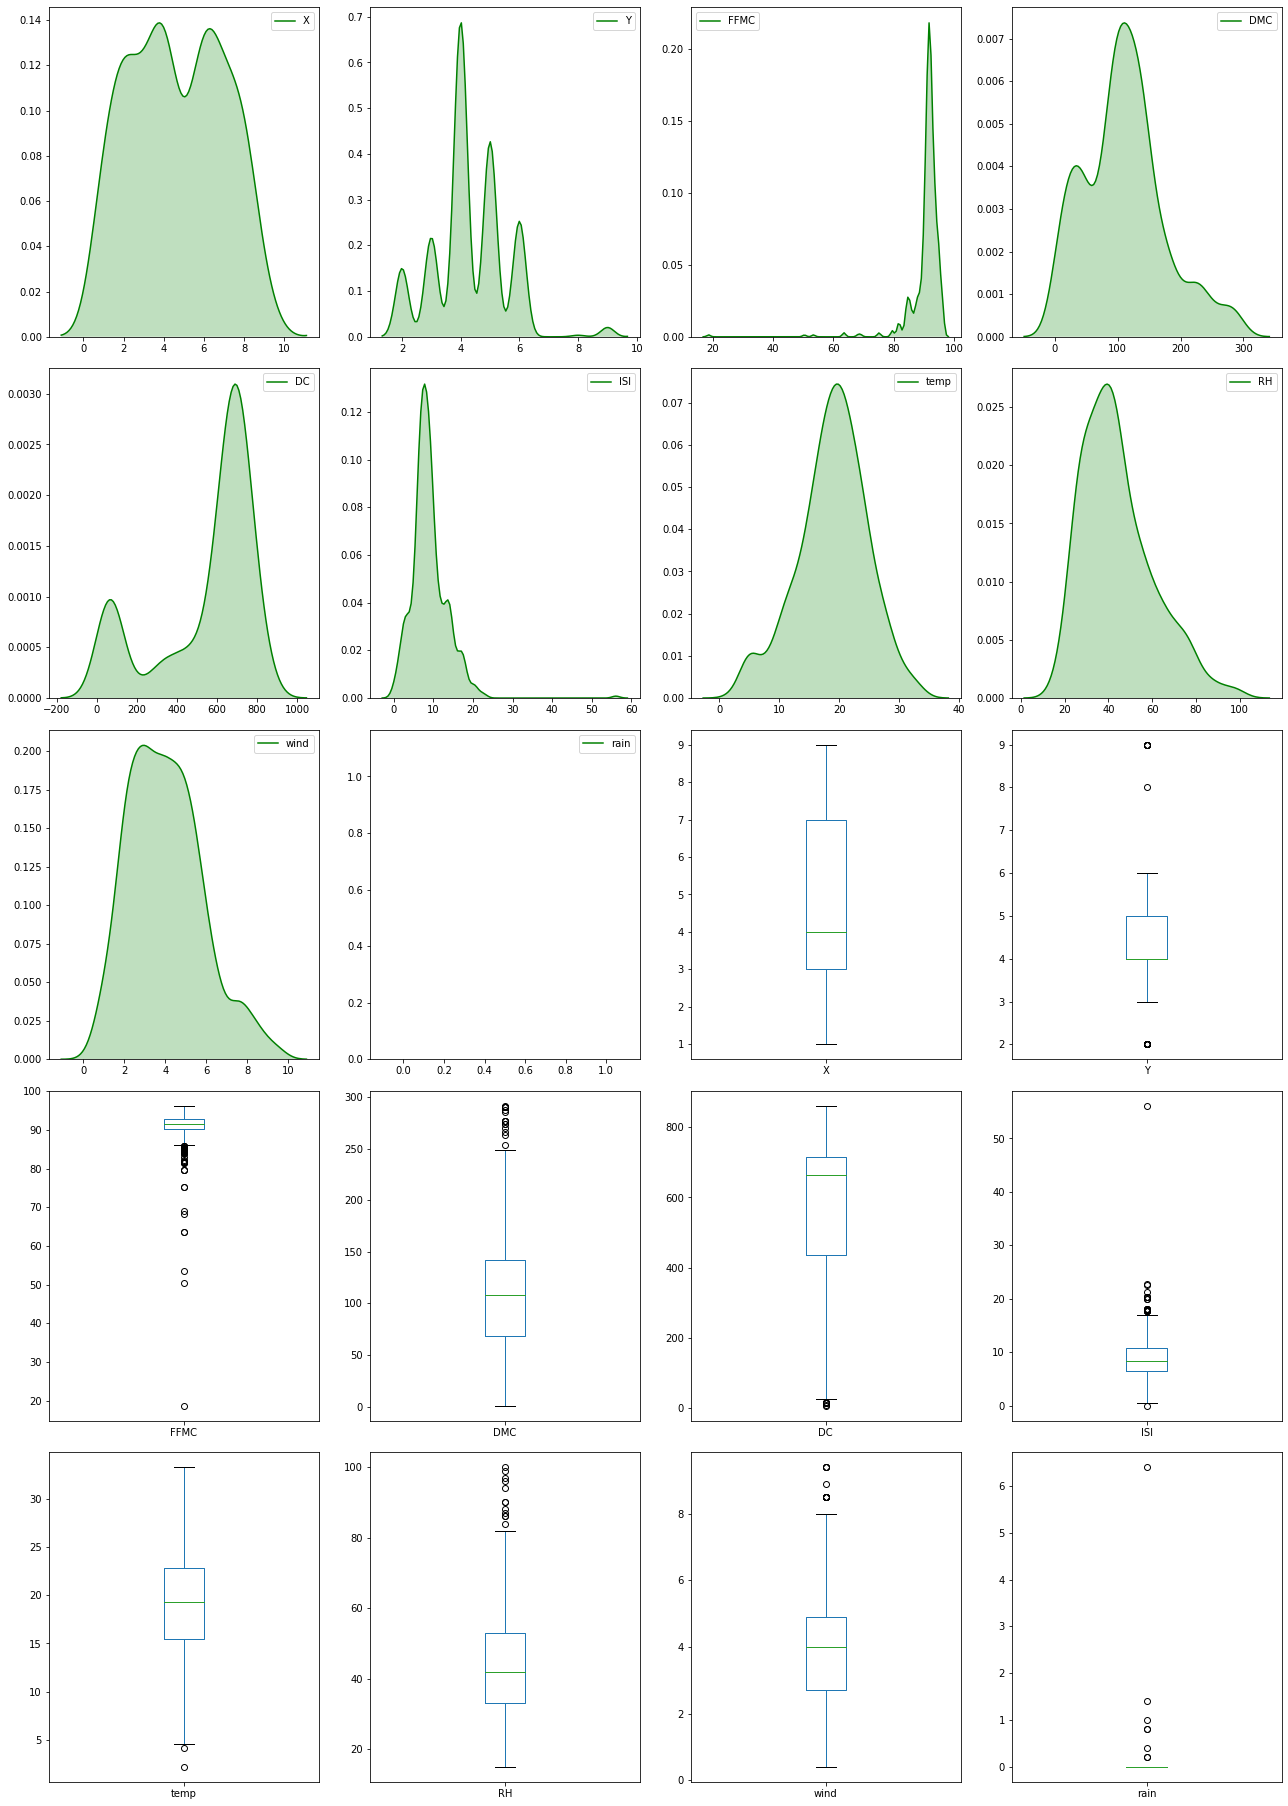

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,0.036246,0.417296,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,-1.172331,1.420553,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


In [14]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])
#the enumerate() method is used to add counter to an iterable and return it.

In [15]:
# a categorical variable based on forest fire area damage
# No damage, low, moderate, high, very high
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage_category
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,No damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,No damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,No damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,No damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,No damage


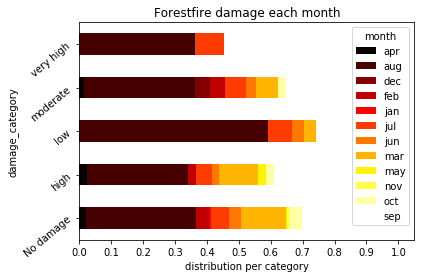

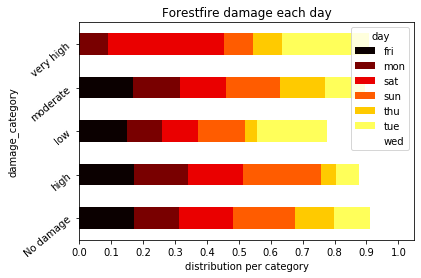

In [16]:
for col in cat_columns:
    cross = pd.crosstab(index=df['damage_category'],columns=df[col],normalize='index')
    cross.plot.barh(stacked=True,rot=40,cmap='hot')
    plt.xlabel('distribution per category')
    plt.xticks(np.arange(0,1.1,0.1))
    plt.title("Forestfire damage each {}".format(col))
plt.show()
#The crosstab() function is used to compute a simple cross tabulation of two(or more) factors.By default computes a frequency table of the factors unless an array of values and an aggregation function are passed.

Previously it had been observed that August and September had the most number of forest fires. And from the above plot of month, it could be understood that-

1.Most of the fires in August were low (< 1 hectare).

2.The very high damages(>100 hectares) happened in only 3 months - august,july and september.

Regarding fire damage per day, nothing much can be observed. Except that, there were no very high damaging fires on Friday and on Saturdays it has been reported most.

In [17]:
out_columns = ['area','FFMC','ISI','rain']

In [18]:
#encoding the categorical values we will use the dummies method from pandas
df = pd.get_dummies(df,columns=['day','month'],drop_first=True)

In [19]:
print(df[out_columns].describe())
np.log1p(df[out_columns]).skew(), np.log1p(df[out_columns]).kurtosis()

              area        FFMC         ISI        rain
count   517.000000  517.000000  517.000000  517.000000
mean     12.847292   90.644681    9.021663    0.021663
std      63.655818    5.520111    4.559477    0.295959
min       0.000000   18.700000    0.000000    0.000000
25%       0.000000   90.200000    6.500000    0.000000
50%       0.520000   91.600000    8.400000    0.000000
75%       6.570000   92.900000   10.800000    0.000000
max    1090.840000   96.200000   56.100000    6.400000


(area     1.217838
 FFMC   -11.675394
 ISI     -0.937218
 rain    14.173028
 dtype: float64,
 area      0.945668
 FFMC    185.482383
 ISI       2.584588
 rain    234.240025
 dtype: float64)

The purpose of using log1p is because-

1.For real-valued input, log1p is accurate also for x so small that 1 + x == 1 in floating-point accuracy.

2.For real-valued input data types, log1p always returns real output. For each value that cannot be expressed as a real number or infinity, it yields nan and sets the invalid floating point error flag.

3.For complex-valued input, log1p is a complex analytical function that has a branch cut [-inf, -1] and is continuous from above on it. log1p handles the floating-point negative zero as an infinitesimal negative number.

In [20]:
# FFMC and rain are still having high skew and kurtosis values, 

# so for FFMC we can remove the outliers in them using z-score method
mask = df.loc[:,['FFMC']].apply(zscore).abs() < 3

# Since most of the values in rain are 0.0, we can convert it as a categorical column
df['rain'] = df['rain'].apply(lambda x: int(x > 0.0))

df = df[mask.values]
df.shape

(510, 29)

In [21]:
df.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0,...,0,0,0,0,0,1,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0,...,0,0,0,0,0,0,0,0,1,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0,...,0,0,0,0,0,0,0,0,1,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,1,...,0,0,0,0,0,1,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0,...,0,0,0,0,0,1,0,0,0,0


In [22]:
out_columns.remove('rain')
df[out_columns] = np.log1p(df[out_columns])

In [23]:
df[out_columns].skew()

area    1.208492
FFMC   -1.803993
ISI    -0.434372
dtype: float64

In [24]:
# we will use this dataframe for building our ML model
df_ml = df.drop(columns=['damage_category']).copy()

In [25]:
df_ml.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,7,5,4.468204,26.2,94.3,1.808289,8.2,51,6.7,0,...,0,0,0,0,0,1,0,0,0,0
1,7,4,4.517431,35.4,669.1,2.041220,18.0,33,0.9,0,...,0,0,0,0,0,0,0,0,1,0
2,7,4,4.517431,43.7,686.9,2.041220,14.6,33,1.3,0,...,0,0,0,0,0,0,0,0,1,0
3,8,6,4.529368,33.3,77.5,2.302585,8.3,97,4.0,1,...,0,0,0,0,0,1,0,0,0,0
4,8,6,4.503137,51.3,102.2,2.360854,11.4,99,1.8,0,...,0,0,0,0,0,1,0,0,0,0


In [26]:
X = df_ml.copy()
y = df['area']

In [27]:
X.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,7,5,4.468204,26.2,94.3,1.808289,8.2,51,6.7,0,...,0,0,0,0,0,1,0,0,0,0
1,7,4,4.517431,35.4,669.1,2.041220,18.0,33,0.9,0,...,0,0,0,0,0,0,0,0,1,0
2,7,4,4.517431,43.7,686.9,2.041220,14.6,33,1.3,0,...,0,0,0,0,0,0,0,0,1,0
3,8,6,4.529368,33.3,77.5,2.302585,8.3,97,4.0,1,...,0,0,0,0,0,1,0,0,0,0
4,8,6,4.503137,51.3,102.2,2.360854,11.4,99,1.8,0,...,0,0,0,0,0,1,0,0,0,0


In [28]:
num_instances = len(X)

models = []
models.append(('LiR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('Bag_Re', BaggingRegressor()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('ExtraTreesRegressor', ExtraTreesRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Evaluations
results = []
names = []
scoring = []

for name, model in models:
    # Fit the model
    model.fit(X, y)
    
    predictions = model.predict(X)
    
    # Evaluate the model
    score = explained_variance_score(y, predictions)
    mae = mean_absolute_error(predictions, y)
    # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    results.append(mae)
    names.append(name)
    
    msg = "%s: %f (%f)" % (name, score, mae)
    print(msg)

LiR: 1.000000 (0.000000)
Ridge: 0.999999 (0.001183)
Lasso: 0.739027 (0.592328)
ElasticNet: 0.834501 (0.471594)
Bag_Re: 0.999630 (0.007389)
RandomForest: 0.999313 (0.005674)
ExtraTreesRegressor: 1.000000 (0.000000)
KNN: 0.287224 (0.921945)
Decision Tree: 1.000000 (0.000000)
SVM: 0.006539 (1.085248)


From above analysis it can be concluded that 'ExtraTreesRegressor' and 'DecisionTreeRegressor' are the best estimators/models for this dataset.

In [29]:
display(X.dtypes)

X              int64
Y              int64
FFMC         float64
DMC          float64
DC           float64
ISI          float64
temp         float64
RH             int64
wind         float64
rain           int64
area         float64
day_mon        uint8
day_sat        uint8
day_sun        uint8
day_thu        uint8
day_tue        uint8
day_wed        uint8
month_aug      uint8
month_dec      uint8
month_feb      uint8
month_jan      uint8
month_jul      uint8
month_jun      uint8
month_mar      uint8
month_may      uint8
month_nov      uint8
month_oct      uint8
month_sep      uint8
dtype: object

In [30]:
#df['FFMC'] = df['FFMC'].apply(np.int64) 
#df['DMC'] = df['DMC'].apply(np.int64) 
#df['DC'] = df['DC'].apply(np.int64) 
#df['ISI'] = df['ISI'].apply(np.int64) 
#df['temp'] = df['temp'].apply(np.int64) 
#df['wind'] = df['wind'].apply(np.int64) 

In [31]:
#display(X.dtypes)

In [32]:
#print(X.round(0).astype(int))

In [33]:
#Xr = X.round(0).astype(int).copy()

In [34]:
#Xr.head()

In [35]:
y = np.array(y).reshape((len(y), 1))
#Y.reshape(-1, 1)

# normalize the dataset
scale = MinMaxScaler(feature_range=(0, 1))
#Y = scale.fit_transform(Y)


In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [37]:
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [38]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [39]:
re = ExtraTreesRegressor(n_estimators =10,criterion='mse',random_state=0)
re.fit(X_train,y_train)

C:\Users\S K Prusti\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ExtraTreesRegressor(n_estimators=10, random_state=0)

In [40]:
y_pred = re.predict(X_test)

In [41]:
re.score(X_test, y_test)

0.9996035928190404

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(mean_squared_error(y_pred, y_test))
print(r2_score(y_pred, y_test))

0.06518122339779364
0.9647383689572977


C:\Users\S K Prusti\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [44]:
print("Training Accuracy = ", regr.score(X_train, y_train))
print("Test Accuracy = ", regr.score(X_test, y_test))

Training Accuracy =  0.9510359528765382
Test Accuracy =  0.9651270848623923
